In [449]:
import os

# # Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed pyspark==2.4.4

openjdk version "1.8.0_275"
OpenJDK Runtime Environment (build 1.8.0_275-8u275-b01-0ubuntu1~18.04-b01)
OpenJDK 64-Bit Server VM (build 25.275-b01, mixed mode)
Processing /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471/pyspark-2.4.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e3/53/c737818eb9a7dc32a7cd4f1396e787bd94200c3997c72c1dbe028587bd76/py4j-0.10.7-py2.py3-none-any.whl


In [450]:
! java -version

openjdk version "1.8.0_275"
OpenJDK Runtime Environment (build 1.8.0_275-8u275-b01-0ubuntu1~18.04-b01)
OpenJDK 64-Bit Server VM (build 25.275-b01, mixed mode)


In [451]:
import sys
import time

#Spark ML and SQL
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql.functions import array_contains
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
import numpy as np
from pyspark.sql.functions import isnan, when, count, col

In [452]:
from pyspark.sql import SparkSession
import pyspark.sql as sparksql
spark = SparkSession.builder.appName('stroke').getOrCreate()
# train = spark.read.csv('https://raw.githubusercontent.com/aman1002/McKinseyOnlineHackathon-Healthcare-/master/train.csv', inferSchema=True,header=True)

In [453]:
import pandas as pd
train = pd.read_csv("https://raw.githubusercontent.com/aman1002/McKinseyOnlineHackathon-Healthcare-/master/train.csv")
train['smoking_status'] = train['smoking_status'].fillna('No Info')
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,No Info,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,No Info,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,No Info,0


In [454]:
train.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [455]:
train['bmi'] = train['bmi'].fillna((train['bmi'].mean()))

In [456]:
train = spark.createDataFrame(train)
train.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|30669|  Male| 3.0|           0|            0|          No|     children|         Rural|            95.12|18.0|        No Info|     0|
|30468|  Male|58.0|           1|            0|         Yes|      Private|         Urban|            87.96|39.2|   never smoked|     0|
|16523|Female| 8.0|           0|            0|          No|      Private|         Urban|           110.89|17.6|        No Info|     0|
|56543|Female|70.0|           0|            0|         Yes|      Private|         Rural|            69.04|35.9|formerly smoked|     0|
|46136|  Male|14.0|           0|            0|         

In [457]:
# fill in miss values for bmi 
# as this is numecial data , we will simple fill the missing values with mean
from pyspark.sql.functions import mean
mean = train.select(mean(train['bmi'])).collect()
mean_bmi = mean[0][0]
print(mean_bmi)
train = train.fillna( { 'bmi':mean_bmi } )
#test = test.fillna( { 'bmi':mean_bmi } )

28.605038390004683


In [458]:
#to print the categories of columns
print(train.select('gender').distinct().rdd.map(lambda r: r[0]).collect())
print(train.select('ever_married').distinct().rdd.map(lambda r: r[0]).collect())
print(train.select('work_type').distinct().rdd.map(lambda r: r[0]).collect())
print(train.select('Residence_type').distinct().rdd.map(lambda r: r[0]).collect())
print(train.select('smoking_status').distinct().rdd.map(lambda r: r[0]).collect())
print(train.select('stroke').distinct().rdd.map(lambda r: r[0]).collect())


['Female', 'Other', 'Male']
['No', 'Yes']
['Never_worked', 'Self-employed', 'Private', 'children', 'Govt_job']
['Urban', 'Rural']
['smokes', 'No Info', 'never smoked', 'formerly smoked']
[0, 1]


In [459]:
train.dtypes

[('id', 'bigint'),
 ('gender', 'string'),
 ('age', 'double'),
 ('hypertension', 'bigint'),
 ('heart_disease', 'bigint'),
 ('ever_married', 'string'),
 ('work_type', 'string'),
 ('Residence_type', 'string'),
 ('avg_glucose_level', 'double'),
 ('bmi', 'double'),
 ('smoking_status', 'string'),
 ('stroke', 'bigint')]

In [460]:


train.select([count(when(isnan(c), c)).alias(c) for c in train.columns]).show()


+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



In [461]:

test = pd.read_csv("https://raw.githubusercontent.com/aman1002/McKinseyOnlineHackathon-Healthcare-/master/test.csv")
test['smoking_status'] = test['smoking_status'].fillna('No Info')
test = spark.createDataFrame(test)
#test.na.fill('No Info', subset=['smoking_status'])
test.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
|36306|  Male|80.0|           0|            0|         Yes|      Private|         Urban|            83.84|21.1|formerly smoked|
|61829|Female|74.0|           0|            1|         Yes|Self-employed|         Rural|            179.5|26.0|formerly smoked|
|14152|Female|14.0|           0|            0|          No|     children|         Rural|            95.16|21.2|        No Info|
|12997|  Male|28.0|           0|            0|          No|      Private|         Urban|            94.76|23.4|        No Info|
|40801|Female|63.0|           0|            0|         Yes|     Govt_job|         Rural|            83.5

In [462]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
a = [IntegerType(),StringType(),IntegerType(),IntegerType(),IntegerType(),
     StringType(),StringType(),StringType(),FloatType(),
     IntegerType(),StringType(),IntegerType()]
print(len(a))
print(len(train.columns))
train = train.withColumn("id", train["id"].cast(IntegerType()))
train = train.withColumn("gender", train["gender"].cast(StringType()))
train = train.withColumn("age", train["age"].cast(IntegerType()))
train = train.withColumn("hypertension", train["hypertension"].cast(IntegerType()))
train = train.withColumn("heart_disease", train["heart_disease"].cast(IntegerType()))
train = train.withColumn("ever_married", train["ever_married"].cast(StringType()))
train = train.withColumn("work_type", train["work_type"].cast(StringType()))
train = train.withColumn("Residence_type", train["Residence_type"].cast(StringType()))
train = train.withColumn("avg_glucose_level", train["avg_glucose_level"].cast(FloatType()))
train = train.withColumn("bmi", train["bmi"].cast(FloatType()))
train = train.withColumn("smoking_status", train["smoking_status"].cast(StringType()))
train = train.withColumn("stroke", train["stroke"].cast(IntegerType()))

  # train = train.withColumn(i, train[i].cast(i))
# train = train.withColumn("Plays", train["Plays"].cast(IntegerType()))

12
12


In [463]:
train.dtypes

[('id', 'int'),
 ('gender', 'string'),
 ('age', 'int'),
 ('hypertension', 'int'),
 ('heart_disease', 'int'),
 ('ever_married', 'string'),
 ('work_type', 'string'),
 ('Residence_type', 'string'),
 ('avg_glucose_level', 'float'),
 ('bmi', 'float'),
 ('smoking_status', 'string'),
 ('stroke', 'int')]

In [464]:
test = test.withColumn("id", test["id"].cast(IntegerType()))
test = test.withColumn("gender", test["gender"].cast(StringType()))
test = test.withColumn("age", test["age"].cast(IntegerType()))
test = test.withColumn("hypertension", test["hypertension"].cast(IntegerType()))
test = test.withColumn("heart_disease", test["heart_disease"].cast(IntegerType()))
test = test.withColumn("ever_married", test["ever_married"].cast(StringType()))
test = test.withColumn("work_type", test["work_type"].cast(StringType()))
test = test.withColumn("Residence_type", test["Residence_type"].cast(StringType()))
test = test.withColumn("avg_glucose_level", test["avg_glucose_level"].cast(FloatType()))
test = test.withColumn("bmi", test["bmi"].cast(FloatType()))
test = test.withColumn("smoking_status", test["smoking_status"].cast(StringType()))

In [465]:
print("The number of row and columns: ")
print(str(train.count())+","+str(len(train.columns)))
 

The number of row and columns: 
43400,12


In [466]:
train=train.dropDuplicates();
totalRow=train.count()
print("The number of row and columns after removing duplicate rows: ")
print(str(totalRow)+","+str(len(train.columns)))

The number of row and columns after removing duplicate rows: 
43400,12


In [467]:
print("nThe type of each column variable")
train.printSchema()

nThe type of each column variable
root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: float (nullable = true)
 |-- bmi: float (nullable = false)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [468]:
print("Data Classes :")
train.groupBy('stroke').count().show()

Data Classes :
+------+-----+
|stroke|count|
+------+-----+
|     1|  783|
|     0|42617|
+------+-----+



In [469]:
train.stat.crosstab("gender", "stroke").show()

+-------------+-----+---+
|gender_stroke|    0|  1|
+-------------+-----+---+
|        Other|   11|  0|
|         Male|17372|352|
|       Female|25234|431|
+-------------+-----+---+



In [470]:
train.stat.crosstab("smoking_status", "stroke").show()

+---------------------+-----+---+
|smoking_status_stroke|    0|  1|
+---------------------+-----+---+
|      formerly smoked| 7272|221|
|              No Info|13147|145|
|               smokes| 6429|133|
|         never smoked|15769|284|
+---------------------+-----+---+



In [471]:
train.describe().show()

+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+-----------------+--------------+-------------------+
|summary|               id|gender|               age|       hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|              bmi|smoking_status|             stroke|
+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+-----------------+--------------+-------------------+
|  count|            43400| 43400|             43400|              43400|              43400|       43400|    43400|         43400|             43400|            43400|         43400|              43400|
|   mean|36326.14235023042|  null| 42.20509216589862|0.09357142857142857|0.04751152073732719|        null|     null|          null|104.48274998273718|28.60503836335125|          null|0

In [472]:
#correlation between age and bmi column
print('correlation among age and bmi', train.stat.corr("age","bmi"))
print('correlation among age and hypertension',  train.stat.corr("age","hypertension"))
print('correlation among age and heart_disease',  train.stat.corr("age","heart_disease"))
print('correlation among age and avg_glucose_level',  train.stat.corr("age","avg_glucose_level"))
print('correlation among bmi and heart_disease',  train.stat.corr("bmi","heart_disease"))
print('correlation among bmi and hypertension',  train.stat.corr("bmi","hypertension"))
print('correlation among bmi and avg_glucose_level',  train.stat.corr("bmi","avg_glucose_level"))
print('correlation among hypertension and avg_glucose_level',  train.stat.corr("hypertension","avg_glucose_level"))
print('correlation among   heart_disease and avg_glucose_level',  train.stat.corr("heart_disease","avg_glucose_level"))
print('correlation among   heart_disease and hypertension',  train.stat.corr("heart_disease","hypertension"))

correlation among age and bmi 0.3526219495747763
correlation among age and hypertension 0.2720674109317827
correlation among age and heart_disease 0.2500543031637834
correlation among age and avg_glucose_level 0.23753865638184568
correlation among bmi and heart_disease 0.05413275950913033
correlation among bmi and hypertension 0.15377892038810498
correlation among bmi and avg_glucose_level 0.184198583300623
correlation among hypertension and avg_glucose_level 0.1602112855742868
correlation among   heart_disease and avg_glucose_level 0.14693806802039466
correlation among   heart_disease and hypertension 0.11977702589069274


In [473]:
# create DataFrame as a temporary view for SQL queries
train.createOrReplaceTempView('table')

In [474]:
# sql query to find the number of people in specific work_type who have had stroke and not
spark.sql("SELECT work_type, COUNT(work_type) as work_type_count FROM table WHERE stroke == 1 GROUP BY work_type ORDER BY COUNT(work_type) DESC").show()
spark.sql("SELECT work_type, COUNT(work_type) as work_type_count FROM table WHERE stroke == 0 GROUP BY work_type ORDER BY COUNT(work_type) DESC").show()
spark.sql("SELECT gender, COUNT(gender) as gender_count, COUNT(gender)*100/(SELECT COUNT(gender) FROM table WHERE gender == 'Male') as percentage FROM table WHERE stroke== 1 AND gender = 'Male' GROUP BY gender").show()
spark.sql("SELECT gender, COUNT(gender) as gender_count, COUNT(gender)*100/(SELECT COUNT(gender) FROM table WHERE gender == 'Female') as percentage FROM table WHERE stroke== 1 AND gender = 'Female' GROUP BY gender").show()

+-------------+---------------+
|    work_type|work_type_count|
+-------------+---------------+
|      Private|            441|
|Self-employed|            251|
|     Govt_job|             89|
|     children|              2|
+-------------+---------------+

+-------------+---------------+
|    work_type|work_type_count|
+-------------+---------------+
|      Private|          24393|
|Self-employed|           6542|
|     children|           6154|
|     Govt_job|           5351|
| Never_worked|            177|
+-------------+---------------+

+------+------------+------------------+
|gender|gender_count|        percentage|
+------+------------+------------------+
|  Male|         352|1.9860076732114647|
+------+------------+------------------+

+------+------------+------------------+
|gender|gender_count|        percentage|
+------+------------+------------------+
|Female|         431|1.6793298266121177|
+------+------------+------------------+



**1.68**% female and almost 2% male had stroke.

Here we see that there are few missing values in smoking_status and bmi column
Also there are few categorical data (gender, ever_married, work_type, Residence_type, smoking_status which we need to covert into one hot encoding

In [475]:
# fill in missing values for smoking status
# As this is categorical data, we will add one data type "No Info" for the missing one
train_f = train
test_f = test

In [476]:
train_f.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: float (nullable = true)
 |-- bmi: float (nullable = false)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [477]:
# from pyspark.sql.functions import mean
# mean = train_f.select(mean(train_f['bmi'])).collect()
# mean_bmi = mean[0][0]
# print(mean_bmi)
# print(mean)

In [478]:
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col

df_stats = train_f.select(
    _mean(col('bmi')).alias('mean'),
    _stddev(col('bmi')).alias('std')
).collect()

mean = df_stats[0]['mean']
std = df_stats[0]['std']
mean

28.60503836335125

In [479]:
train_f.describe().show()

+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+-----------------+--------------+-------------------+
|summary|               id|gender|               age|       hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|              bmi|smoking_status|             stroke|
+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+-----------------+--------------+-------------------+
|  count|            43400| 43400|             43400|              43400|              43400|       43400|    43400|         43400|             43400|            43400|         43400|              43400|
|   mean|36326.14235023042|  null| 42.20509216589862|0.09357142857142857|0.04751152073732719|        null|     null|          null|104.48274998273718|28.60503836335125|          null|0

In [480]:
test_f.describe().show()

+-------+------------------+------+------------------+-------------------+--------------------+------------+---------+--------------+------------------+-----+--------------+
|summary|                id|gender|               age|       hypertension|       heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|  bmi|smoking_status|
+-------+------------------+------+------------------+-------------------+--------------------+------------+---------+--------------+------------------+-----+--------------+
|  count|             18601| 18601|             18601|              18601|               18601|       18601|    18601|         18601|             18601|18601|         18601|
|   mean| 36747.36804472878|  null|42.043868609214556|0.09316703403042847|0.048061932154185256|        null|     null|          null|104.38635932680779|  NaN|          null|
| stddev|21053.151123778687|  null| 22.55112733897937|0.29067418204733125| 0.21390288127048418|        null|     null|          nu

Now there is no missing values, Lets work on categorical columns now...

StringIndexer -> OneHotEncoder -> VectorAssembler

In [481]:
# indexing all categorical columns in the dataset
from pyspark.ml.feature import StringIndexer
indexer1 = StringIndexer(inputCol="gender", outputCol="genderIndex")
indexer2 = StringIndexer(inputCol="ever_married", outputCol="ever_marriedIndex")
indexer3 = StringIndexer(inputCol="work_type", outputCol="work_typeIndex")
indexer4 = StringIndexer(inputCol="Residence_type", outputCol="Residence_typeIndex")
indexer5 = StringIndexer(inputCol="smoking_status", outputCol="smoking_statusIndex")

In [482]:
from pyspark.ml.feature import OneHotEncoderEstimator
encoder = OneHotEncoderEstimator(inputCols=["genderIndex","ever_marriedIndex","work_typeIndex","Residence_typeIndex","smoking_statusIndex"],
                                 outputCols=["genderVec","ever_marriedVec","work_typeVec","Residence_typeVec","smoking_statusVec"])

In [483]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['genderVec',
 'age',
 'hypertension',
 'heart_disease',
 'ever_marriedVec',
 'work_typeVec',
 'Residence_typeVec',
 'avg_glucose_level',
 'bmi',
 'smoking_statusVec'],outputCol='features')

In [484]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, encoder, assembler, dtc])

In [485]:
# Doing one hot encoding of indexed data
from pyspark.ml.feature import OneHotEncoderEstimator
encoder = OneHotEncoderEstimator(inputCols=["genderIndex","ever_marriedIndex","work_typeIndex","Residence_typeIndex","smoking_statusIndex"],
                                 outputCols=["genderVec","ever_marriedVec","work_typeVec","Residence_typeVec","smoking_statusVec"])

In [486]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['genderVec',
 'age',
 'hypertension',
 'heart_disease',
 'ever_marriedVec',
 'work_typeVec',
 'Residence_typeVec',
 'avg_glucose_level',
 'bmi',
 'smoking_statusVec'],outputCol='features')

In [487]:
# splitting training and validation data
train_data,val_data = train_f.randomSplit([0.7,0.3])


Random Forest


In [488]:
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import  matplotlib.pyplot as plt
import numpy as np
import itertools
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



In [489]:
rfc = RandomForestClassifier(labelCol='stroke',featuresCol='features')
pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, encoder, assembler, rfc])
# training model pipeline with data
model = pipeline.fit(train_data)
# making prediction on model with validation data
rfc_predictions = model.transform(val_data)
# Select (prediction, true label) and compute test error
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
rfc_acc = acc_evaluator.evaluate(rfc_predictions)
print('A Random Forest algorithm had an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
# Select (prediction, true label) and compute test error
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="f1")
#evaluator = BinaryClassificationEvaluator()
rfc_acc = acc_evaluator.evaluate(rfc_predictions)
print('A Random Forest algorithm had an F1-Score of: {0:2.2f}%'.format(rfc_acc*100))
#AUC
evaluator = BinaryClassificationEvaluator(labelCol="stroke")
print('Test Area Under ROC', evaluator.evaluate(rfc_predictions))

A Random Forest algorithm had an accuracy of: 98.22%
A Random Forest algorithm had an F1-Score of: 97.34%
Test Area Under ROC 0.8358355738498021


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12932
           1       0.00      0.00      0.00       234

    accuracy                           0.98     13166
   macro avg       0.49      0.50      0.50     13166
weighted avg       0.96      0.98      0.97     13166

Confusion matrix, without normalization
[[12932     0]
 [  234     0]]


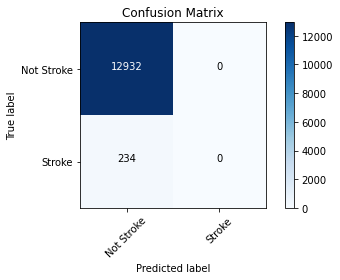

In [490]:
y_true = rfc_predictions.select(['stroke']).collect()
y_pred = rfc_predictions.select(['prediction']).collect()
print(classification_report(y_true, y_pred))

# argmax returns the index of the max value in a row
cm = confusion_matrix(y_true, y_pred)
cm_plot_labels = ['Not Stroke', 'Stroke']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [491]:


# Select example rows to display.
test_selected = rfc_predictions .select("id", "features", "prediction","probability")
test_selected.limit(5).toPandas()

,id,features,prediction,probability
0,899,"(1.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0.0,"[0.9879649107285038, 0.012035089271496142]"
1,1521,"(1.0, 0.0, 17.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...",0.0,"[0.9872669566246552, 0.012733043375344862]"
2,2844,"(0.0, 1.0, 21.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...",0.0,"[0.9869266267502438, 0.013073373249756281]"
3,2883,"(1.0, 0.0, 69.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...",0.0,"[0.9635631272345032, 0.03643687276549675]"
4,3071,"(1.0, 0.0, 69.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0,...",0.0,"[0.9774076183689575, 0.022592381631042595]"


In [492]:
from pyspark.ml.classification import LogisticRegression
lg = LogisticRegression(labelCol='stroke',featuresCol='features')
pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, encoder, assembler, lg])
# training model pipeline with data
model = pipeline.fit(train_data)
# making prediction on model with validation data
lg_predictions = model.transform(val_data)
# Select (prediction, true label) and compute test error
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
lg_acc = acc_evaluator.evaluate(lg_predictions)
print('A Logistic Regression algorithm had an accuracy of: {0:2.2f}%'.format(lg_acc*100))
# Select (prediction, true label) and compute test error
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="f1")
#evaluator = BinaryClassificationEvaluator()
lg_acc = acc_evaluator.evaluate(lg_predictions)
print('A logistic algorithm had an F1-Score of: {0:2.2f}%'.format(lg_acc*100))
#AUC
evaluator = BinaryClassificationEvaluator(labelCol="stroke")
print('Test Area Under ROC', evaluator.evaluate(lg_predictions))

A Logistic Regression algorithm had an accuracy of: 98.22%
A logistic algorithm had an F1-Score of: 97.34%
Test Area Under ROC 0.8557712135271681


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12932
           1       0.00      0.00      0.00       234

    accuracy                           0.98     13166
   macro avg       0.49      0.50      0.50     13166
weighted avg       0.96      0.98      0.97     13166

Confusion matrix, without normalization
[[12932     0]
 [  234     0]]


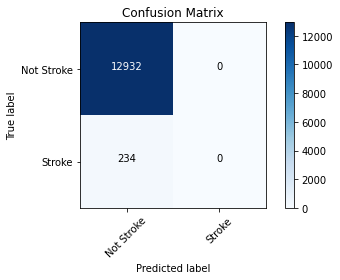

In [493]:
y_true = lg_predictions.select(['stroke']).collect()
y_pred = lg_predictions.select(['prediction']).collect()
print(classification_report(y_true, y_pred))

# argmax returns the index of the max value in a row
cm = confusion_matrix(y_true, y_pred)
cm_plot_labels = ['Not Stroke', 'Stroke']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [494]:
# balancing the dataset by duplicating the minority class samples
from pyspark.sql.functions import col, explode, array, lit,ceil
train_data
major_df = train_data.filter(col("stroke") == 0)
print(major_df.count())
minor_df = train_data.filter(col("stroke") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

29685
ratio: 54


In [495]:
a = range(ratio+1)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
combined_df = major_df.unionAll(oversampled_df)
combined_df.show()
print(combined_df.count())

+----+------+---+------------+-------------+------------+-------------+--------------+-----------------+---------+---------------+------+
|  id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level|      bmi| smoking_status|stroke|
+----+------+---+------------+-------------+------------+-------------+--------------+-----------------+---------+---------------+------+
| 189|  Male| 65|           0|            0|         Yes|Self-employed|         Rural|            74.66|     30.6|formerly smoked|     0|
| 695|Female| 60|           0|            0|         Yes|      Private|         Rural|           103.25|     26.2|         smokes|     0|
|2143|Female| 74|           0|            0|         Yes|      Private|         Urban|            91.34|     22.0|formerly smoked|     0|
|2365|Female| 76|           0|            0|         Yes|      Private|         Urban|            95.94|     28.7|   never smoked|     0|
|3019|Female| 36|           0|    

In [496]:

train_data=combined_df

In [497]:
#random forest
rfc = RandomForestClassifier(labelCol='stroke',featuresCol='features')
pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, encoder, assembler, rfc])


# training model pipeline with data
model = pipeline.fit(train_data)
# making prediction on model with validation data
rfc_predictions = model.transform(val_data)
# Select (prediction, true label) and compute test error
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
rfc_acc = acc_evaluator.evaluate(rfc_predictions)
print('A Random Forest algorithm had an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
# Select (prediction, true label) and compute test error
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="f1")
#evaluator = BinaryClassificationEvaluator()
rfc_acc = acc_evaluator.evaluate(rfc_predictions)
print('A Random Forest algorithm had an F1-Score of: {0:2.2f}%'.format(rfc_acc*100))
#AUC
evaluator = BinaryClassificationEvaluator(labelCol="stroke")
print('Test Area Under ROC', evaluator.evaluate(rfc_predictions))

A Random Forest algorithm had an accuracy of: 69.44%
A Random Forest algorithm had an F1-Score of: 80.35%
Test Area Under ROC 0.8411891855094761


              precision    recall  f1-score   support

           0       1.00      0.69      0.82     12932
           1       0.05      0.84      0.09       234

    accuracy                           0.69     13166
   macro avg       0.52      0.77      0.45     13166
weighted avg       0.98      0.69      0.80     13166

Confusion matrix, without normalization
[[8946 3986]
 [  37  197]]


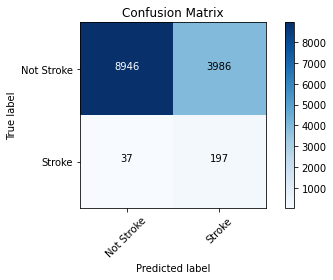

In [498]:
y_true = rfc_predictions.select(['stroke']).collect()
y_pred = rfc_predictions.select(['prediction']).collect()
print(classification_report(y_true, y_pred))

# argmax returns the index of the max value in a row
cm = confusion_matrix(y_true, y_pred)
cm_plot_labels = ['Not Stroke', 'Stroke']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [499]:
#logistic Regression
lg = LogisticRegression(labelCol='stroke',featuresCol='features')
pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, encoder, assembler, lg])
# training model pipeline with data
model = pipeline.fit(train_data)
# making prediction on model with validation data
lg_predictions = model.transform(val_data)
# Select (prediction, true label) and compute test error
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
lg_acc = acc_evaluator.evaluate(lg_predictions)
print('A Logistic Regression algorithm had an accuracy of: {0:2.2f}%'.format(lg_acc*100))
# Select (prediction, true label) and compute test error
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="f1")
#evaluator = BinaryClassificationEvaluator()
lg_acc = acc_evaluator.evaluate(lg_predictions)
print('A Random Forest algorithm had an F1-Score of: {0:2.2f}%'.format(lg_acc*100))
#AUC
evaluator = BinaryClassificationEvaluator(labelCol="stroke")
print('Test Area Under ROC', evaluator.evaluate(lg_predictions))


A Logistic Regression algorithm had an accuracy of: 73.96%
A Random Forest algorithm had an F1-Score of: 83.45%
Test Area Under ROC 0.8554549636362195


              precision    recall  f1-score   support

           0       1.00      0.74      0.85     12932
           1       0.05      0.81      0.10       234

    accuracy                           0.74     13166
   macro avg       0.52      0.77      0.47     13166
weighted avg       0.98      0.74      0.83     13166

Confusion matrix, without normalization
[[9549 3383]
 [  45  189]]


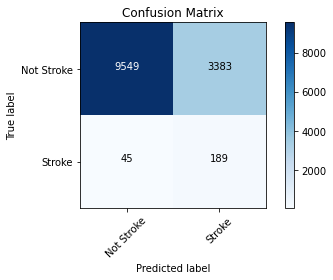

In [500]:

y_true = lg_predictions.select(['stroke']).collect()
y_pred = lg_predictions.select(['prediction']).collect()
print(classification_report(y_true, y_pred))

# argmax returns the index of the max value in a row
cm = confusion_matrix(y_true, y_pred)
cm_plot_labels = ['Not Stroke', 'Stroke']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')